# EEGDash example for eyes open vs. closed classification

The code below provides an example of using the *EEGDash* library in combination with PyTorch to develop a deep learning model for analyzing EEG data, specifically for eyes open vs. closed classification in a single subject.

1. **Data Retrieval Using EEGDash**: An instance of *EEGDashDataset* is created to search and retrieve an EEG dataset. At this step, only the metadata is transferred.

2. **Data Preprocessing Using BrainDecode**: This process preprocesses EEG data using Braindecode by reannotating events, selecting specific channels, resampling, filtering, and extracting 2-second epochs, ensuring balanced eyes-open and eyes-closed data for analysis.
   
3. **Extracting EEG Features Using EEGDash.features**: Building a feature extraction tree using existing and new features.

4. **Creating train and testing sets**: The dataset is split into training (80%) and testing (20%) sets with balanced labels, converted into PyTorch tensors, and wrapped in DataLoader objects for efficient mini-batch training.

5. **Model Definition**: The model is a MLP with `n_features` input channels, 2 output classes (eyes-open and eyes-closed).

6. **Model Training and Evaluation Process**: This section trains the neural network, computes cross-entropy loss, updates model parameters, and evaluates classication accuracy over six epochs.



## Data Retrieval Using EEGDash

First we find one resting state dataset. This dataset contains both eyes open and eyes closed data.

In [1]:
from eegdash import EEGDashDataset

ds_eoec = EEGDashDataset({'dataset': 'ds005514', 'task': 'RestingState', 'subject': 'NDARDB033FW5'})

## Data Preprocessing Using Braindecode

[BrainDecode](https://braindecode.org/stable/install/install.html) is a specialized library for preprocessing EEG and MEG data. In this dataset, there are two key events in the continuous data: **instructed_toCloseEyes**, marking the start of a 40-second eyes-closed period, and **instructed_toOpenEyes**, indicating the start of a 20-second eyes-open period.

For the eyes-closed event, we extract 14 seconds of data from 15 to 29 seconds after the event onset. Similarly, for the eyes-open event, we extract data from 5 to 19 seconds after the event onset. This ensures an equal amount of data for both conditions. The event extraction is handled by the custom function **hbn_ec_ec_reannotation**.

Next, we apply four preprocessing steps in Braindecode:
1.	**Reannotation** of event markers using hbn_ec_ec_reannotation().
2.	**Selection** of 24 specific EEG channels from the original 128.
3.	**Resampling** the EEG data to a frequency of 128 Hz.
4.	**Filtering** the EEG signals to retain frequencies between 1 Hz and 55 Hz.

When calling the **preprocess** function, the data is retrieved from the remote repository.

Finally, we use **create_windows_from_events** to extract 5-second epochs from the data. These epochs serve as the dataset samples. At this stage, each sample is automatically labeled with the corresponding event type (eyes-open or eyes-closed). windows_ds is a PyTorch dataset, and when queried, it returns labels for eyes-open and eyes-closed (assigned as labels 0 and 1, corresponding to their respective event markers).

In [2]:
from braindecode.preprocessing import (preprocess, Preprocessor, create_windows_from_events)
import numpy as np
import mne
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

class hbn_ec_ec_reannotation(Preprocessor):
    def __init__(self):
        super().__init__(fn=self.transform, apply_on_array=False)  # Pass the transform method as the function
    
    def transform(self, raw):  # Changed from 'apply' to 'transform'
        # Create events array from annotations
        events, event_id = mne.events_from_annotations(raw)
        
        print(event_id)

        # Create new events array for 2-second segments
        new_events = []
        sfreq = raw.info['sfreq']
        for event in events[events[:, 2] == event_id['instructed_toCloseEyes']]:
            # For each original event, create events every 2 seconds from 15s to 29s after
            start_times = event[0] + np.arange(15, 29, 2) * sfreq
            new_events.extend([[int(t), 0, 1] for t in start_times])

        for event in events[events[:, 2] == event_id['instructed_toOpenEyes']]:
            # For each original event, create events every 2 seconds from 5s to 19s after
            start_times = event[0] + np.arange(5, 19, 2) * sfreq
            new_events.extend([[int(t), 0, 2] for t in start_times])

        # replace events in raw
        new_events = np.array(new_events)
        annot_from_events = mne.annotations_from_events(
            events=new_events,
            event_desc={1: 'eyes_closed', 2: 'eyes_open'},
            sfreq=raw.info['sfreq']
        )
        raw.set_annotations(annot_from_events)        
        return raw
    
# BrainDecode preprocessors
preprocessors = [
    hbn_ec_ec_reannotation(),
    Preprocessor('pick_channels', ch_names=['E22', 'E9', 'E33', 'E24', 'E11', 'E124', 'E122', 'E29', 'E6', 'E111', 'E45', 'E36', 'E104', 'E108', 'E42', 'E55', 'E93', 'E58', 'E52', 'E62', 'E92', 'E96', 'E70', 'Cz']),
    Preprocessor("resample", sfreq=128),
    Preprocessor("filter", l_freq=1, h_freq=55)
]
preprocess(ds_eoec, preprocessors)

# Extract 2-second segments
windows_ds = create_windows_from_events(
    ds_eoec,
    trial_start_offset_samples=0,
    trial_stop_offset_samples=int(5 * ds_eoec.datasets[0].raw.info["sfreq"]),
    preload=True,
)


Used Annotations descriptions: [np.str_('boundary'), np.str_('break cnt'), np.str_('instructed_toCloseEyes'), np.str_('instructed_toOpenEyes'), np.str_('resting_start')]
{np.str_('boundary'): 1, np.str_('break cnt'): 2, np.str_('instructed_toCloseEyes'): 3, np.str_('instructed_toOpenEyes'): 4, np.str_('resting_start'): 5}
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 9.00 Hz (-6 dB cutoff frequency: 59.50 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: [np.s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


## Plotting a Single Channel for One Sample

It’s always a good practice to verify that the data has been properly loaded and processed. Here, we plot a single channel from one sample to ensure the signal is present and looks as expected.

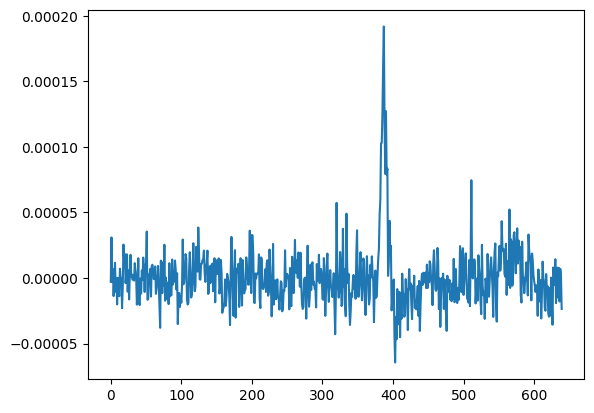

In [3]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(windows_ds[2][0][0,:].transpose()) # first channel of first epoch
plt.show()

## Features

* We start by extracting the signal variance from each channel (EEG electrode) as a feature, so we get 24 features (one per channel).
  
* The function `signal_variance_feature` gets a *batch* of samples, represented by a numpy array of size (`batch_size`$\times$`num_channels`$\times$`time_points_per_window`).
  
* The function returns a numpy array of size (`batch_size`$\times$`num_channels`).
  
* To automatically match the channel name to each feature, we use the `univariate_feature` decorator.
  
* The features extraction is performed by the `extract_features` function, getting a `braindecode` windows dataset and a features dictionary mapping feature names to feature extraction functions.

In [4]:
from eegdash import features
from eegdash.features import extract_features

@features.univariate_feature
def signal_variaince_feature(x):
    return x.var(axis=-1)

features_dict = {
    "sig_var": signal_variaince_feature
}

features_ds = extract_features(windows_ds, features_dict, batch_size=512)

Extracting features: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s]


Let us have a look at the feature values.

In this example, the first three columns represent the window crop indices, and are optional.

In [5]:
features_ds.to_dataframe(include_crop_inds=True)

,i_dataset,i_stop_in_trial,i_window_in_trial,i_start_in_trial,sig_var_E22,sig_var_E9,sig_var_E33,sig_var_E24,sig_var_E11,sig_var_E124,...,sig_var_E42,sig_var_E55,sig_var_E93,sig_var_E58,sig_var_E52,sig_var_E62,sig_var_E92,sig_var_E96,sig_var_E70,sig_var_Cz
0,0,8732,0,8092,8.083553e-10,1.009306e-09,4.005693e-10,2.785240e-10,1.091601e-10,1.014037e-10,...,2.175083e-10,4.566301e-11,9.770358e-11,1.735369e-10,9.738554e-11,1.212567e-10,8.040424e-11,1.296996e-10,1.617177e-10,0.0
1,0,8988,0,8348,2.837207e-10,2.973137e-10,1.613417e-10,2.146816e-10,5.291878e-11,6.577322e-11,...,6.126806e-11,4.315479e-11,5.272704e-11,1.323616e-10,7.812296e-11,1.177541e-10,6.546753e-11,1.084199e-10,1.139587e-10,0.0
2,0,9244,0,8604,5.216351e-10,6.538807e-10,1.423635e-10,2.276002e-10,8.996898e-11,7.892762e-11,...,5.314400e-11,4.220290e-11,4.919443e-11,1.203647e-10,6.875450e-11,1.170081e-10,7.314721e-11,1.193921e-10,1.121259e-10,0.0
3,0,9500,0,8860,5.626777e-10,7.046209e-10,1.829523e-10,2.515951e-10,9.388083e-11,8.017868e-11,...,5.974976e-11,4.462957e-11,6.063729e-11,1.309459e-10,7.662133e-11,1.293457e-10,9.399868e-11,1.458331e-10,1.368829e-10,0.0
4,0,9756,0,9116,2.899944e-10,3.242009e-10,1.915664e-10,2.007668e-10,4.500661e-11,6.651198e-11,...,5.689642e-11,4.419103e-11,5.781762e-11,1.183376e-10,7.552857e-11,1.268692e-10,8.603572e-11,1.287156e-10,1.188040e-10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0,43803,0,43163,2.915335e-10,4.620125e-10,3.015261e-10,1.333517e-10,8.859743e-11,1.155020e-10,...,1.381771e-10,4.795951e-11,1.652881e-10,4.187589e-10,2.035297e-10,1.576439e-10,2.015162e-10,3.637367e-10,3.338940e-10,0.0
66,0,44059,0,43419,4.380371e-10,5.992871e-10,3.121722e-10,1.358803e-10,8.177100e-11,1.103530e-10,...,1.182402e-10,4.364888e-11,1.449913e-10,4.301752e-10,1.949363e-10,1.440090e-10,1.704272e-10,3.789742e-10,3.545432e-10,0.0
67,0,44315,0,43675,1.447384e-07,1.846365e-08,3.329139e-10,4.734372e-10,3.247488e-09,1.100945e-09,...,1.439201e-10,4.929652e-11,1.549540e-10,4.064747e-10,2.260913e-10,1.494364e-10,2.156302e-10,4.107172e-10,3.021709e-10,0.0
68,0,44571,0,43931,1.453834e-07,1.961461e-08,2.680551e-10,4.612319e-10,3.303167e-09,1.090016e-09,...,1.207115e-10,5.020827e-11,1.394705e-10,3.894303e-10,1.960500e-10,1.529962e-10,2.034251e-10,3.562738e-10,3.080394e-10,0.0


* Now we add two spectral features: the root of the total power, and the power in different power bands.
  
* Keyword parameters can be passed to each feature using the `functools.partial` function.

* Multiple similar features can be returned from a feature extraction function by passing a dictionary of numpy arrays.

In [6]:
from functools import partial
from scipy.signal import welch

sfreq = windows_ds.datasets[0].raw.info["sfreq"]


@features.univariate_feature
def spectral_root_total_power_feature(x, **kwargs):
    f, p = welch(x, **kwargs)
    return p.sum(axis=-1)

DEFAULT_FREQ_BANDS = {
    "delta": (1, 4.5),
    "theta": (4.5, 8),
    "alpha": (8, 12),
    "beta": (12, 30),
}

@features.univariate_feature
def spectral_power_bands_feature(x, bands=DEFAULT_FREQ_BANDS, **kwargs):
    f, p = welch(x, **kwargs)
    power_bands = dict()
    for band_name, band_lims in bands.items():
        ind = np.logical_and(f > band_lims[0], f < band_lims[1])
        power_bands[band_name] = p[..., ind].sum(axis=-1)
    return power_bands


features_dict = {
    "sig_var": signal_variaince_feature,
    "spec_rtotpow": partial(spectral_root_total_power_feature, fs=sfreq),
    "sig_pband": partial(spectral_power_bands_feature, fs=sfreq),
}

features_ds = extract_features(windows_ds, features_dict, batch_size=512)

Extracting features: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


Again, let us have a look at the feature values (this time without the window crop indices).

In [7]:
features_ds.to_dataframe()

,sig_var_E22,sig_var_E9,sig_var_E33,sig_var_E24,sig_var_E11,sig_var_E124,sig_var_E122,sig_var_E29,sig_var_E6,sig_var_E111,...,sig_pband_beta_E42,sig_pband_beta_E55,sig_pband_beta_E93,sig_pband_beta_E58,sig_pband_beta_E52,sig_pband_beta_E62,sig_pband_beta_E92,sig_pband_beta_E96,sig_pband_beta_E70,sig_pband_beta_Cz
0,8.083553e-10,1.009306e-09,4.005693e-10,2.785240e-10,1.091601e-10,1.014037e-10,3.488330e-10,9.177432e-11,1.510523e-11,7.204014e-11,...,4.591130e-11,3.674550e-12,4.767839e-11,6.710560e-11,4.781959e-11,1.552441e-11,3.354401e-11,4.266805e-11,6.295796e-11,0.0
1,2.837207e-10,2.973137e-10,1.613417e-10,2.146816e-10,5.291878e-11,6.577322e-11,1.854412e-10,5.901417e-11,1.604059e-11,3.470459e-11,...,2.803337e-11,3.041732e-12,2.264953e-11,6.736097e-11,3.801661e-11,1.312716e-11,2.594218e-11,3.975232e-11,5.963691e-11,0.0
2,5.216351e-10,6.538807e-10,1.423635e-10,2.276002e-10,8.996898e-11,7.892762e-11,1.579518e-10,4.700612e-11,1.697320e-11,2.506564e-11,...,2.404570e-11,2.957664e-12,2.248308e-11,6.538485e-11,2.970460e-11,1.347732e-11,3.109257e-11,4.958662e-11,6.264416e-11,0.0
3,5.626777e-10,7.046209e-10,1.829523e-10,2.515951e-10,9.388083e-11,8.017868e-11,1.707304e-10,4.976460e-11,1.783521e-11,2.263842e-11,...,2.697748e-11,3.247816e-12,2.186173e-11,6.109859e-11,3.445992e-11,1.588805e-11,2.987366e-11,5.177597e-11,6.327393e-11,0.0
4,2.899944e-10,3.242009e-10,1.915664e-10,2.007668e-10,4.500661e-11,6.651198e-11,1.595400e-10,4.853329e-11,1.446429e-11,2.041134e-11,...,2.409690e-11,3.432723e-12,2.213814e-11,5.009781e-11,3.089220e-11,1.633259e-11,3.188099e-11,4.725331e-11,4.943748e-11,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2.915335e-10,4.620125e-10,3.015261e-10,1.333517e-10,8.859743e-11,1.155020e-10,4.127101e-10,6.790383e-11,2.076597e-11,8.582843e-11,...,3.683782e-11,3.630857e-12,5.293001e-11,7.083336e-11,4.110124e-11,1.761718e-11,4.515170e-11,6.633873e-11,6.427854e-11,0.0
66,4.380371e-10,5.992871e-10,3.121722e-10,1.358803e-10,8.177100e-11,1.103530e-10,3.863413e-10,6.075603e-11,1.905322e-11,9.012550e-11,...,4.159459e-11,3.377336e-12,5.496549e-11,8.133459e-11,5.098148e-11,1.825001e-11,4.521704e-11,5.921073e-11,7.274951e-11,0.0
67,1.447384e-07,1.846365e-08,3.329139e-10,4.734372e-10,3.247488e-09,1.100945e-09,3.770637e-10,1.124263e-10,1.014892e-10,1.162441e-10,...,4.954367e-11,4.562075e-12,5.492839e-11,1.302537e-10,7.164367e-11,2.576997e-11,7.220222e-11,9.590631e-11,9.445759e-11,0.0
68,1.453834e-07,1.961461e-08,2.680551e-10,4.612319e-10,3.303167e-09,1.090016e-09,2.984169e-10,9.786222e-11,1.025287e-10,1.047657e-10,...,4.122378e-11,4.909306e-12,5.689239e-11,1.296930e-10,6.114401e-11,2.627740e-11,8.062852e-11,1.032541e-10,9.637122e-11,0.0


You might have noticed that both of the spectral feature extraction functions call the `welch` function with exact same parameters, so the computation will happen twice. As we may add more spectral features, this repeting computation will slow down the feature extraction computations. This can be solved by creating a mid-step computation of the power spectrum, then reusing its result to compute different spectral features.

* Mid-step computations is implemented by inheriting the `FeatureExtractor` class and overriding its `preprocess` method.

* The output of the `preprocess` method will pass as-is to downstream feature extraction functions.

* The `FeaturePredecessor` decorator is used to make sure each feature extraction function recieves a properly preprocessed input.

* The new processing step is included as a new feature, getting its own decendants in a new features dictionary. The feature names will be a concatenation of the processing steps.

In [8]:
sfreq = windows_ds.datasets[0].raw.info["sfreq"]


class WelchFeatureExtractor(features.FeatureExtractor):
    def preprocess(self, x, **kwargs):
        f, p = welch(x, **kwargs)
        return f, p

@features.FeaturePredecessor(WelchFeatureExtractor)
@features.univariate_feature
def spectral_root_total_power_feature(f, p, **kwargs):
    return p.sum(axis=-1)

@features.FeaturePredecessor(WelchFeatureExtractor)
@features.univariate_feature
def spectral_power_bands_feature(f, p, bands=DEFAULT_FREQ_BANDS, **kwargs):
    power_bands = dict()
    for band_name, band_lims in bands.items():
        ind = np.logical_and(f > band_lims[0], f < band_lims[1])
        power_bands[band_name] = p[..., ind].sum(axis=-1)
    return power_bands


features_dict = {
    "sig_var": signal_variaince_feature,
    "spec": WelchFeatureExtractor({
        "rtotpow": spectral_root_total_power_feature,
        "pband": spectral_power_bands_feature,
    }, fs=sfreq)
}

features_ds = extract_features(windows_ds, features_dict, batch_size=512)

Extracting features: 100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


Again, let us have a look at the feature values.

In [9]:
features_ds.to_dataframe()

,sig_var_E22,sig_var_E9,sig_var_E33,sig_var_E24,sig_var_E11,sig_var_E124,sig_var_E122,sig_var_E29,sig_var_E6,sig_var_E111,...,spec_pband_beta_E42,spec_pband_beta_E55,spec_pband_beta_E93,spec_pband_beta_E58,spec_pband_beta_E52,spec_pband_beta_E62,spec_pband_beta_E92,spec_pband_beta_E96,spec_pband_beta_E70,spec_pband_beta_Cz
0,8.083553e-10,1.009306e-09,4.005693e-10,2.785240e-10,1.091601e-10,1.014037e-10,3.488330e-10,9.177432e-11,1.510523e-11,7.204014e-11,...,4.591130e-11,3.674550e-12,4.767839e-11,6.710560e-11,4.781959e-11,1.552441e-11,3.354401e-11,4.266805e-11,6.295796e-11,0.0
1,2.837207e-10,2.973137e-10,1.613417e-10,2.146816e-10,5.291878e-11,6.577322e-11,1.854412e-10,5.901417e-11,1.604059e-11,3.470459e-11,...,2.803337e-11,3.041732e-12,2.264953e-11,6.736097e-11,3.801661e-11,1.312716e-11,2.594218e-11,3.975232e-11,5.963691e-11,0.0
2,5.216351e-10,6.538807e-10,1.423635e-10,2.276002e-10,8.996898e-11,7.892762e-11,1.579518e-10,4.700612e-11,1.697320e-11,2.506564e-11,...,2.404570e-11,2.957664e-12,2.248308e-11,6.538485e-11,2.970460e-11,1.347732e-11,3.109257e-11,4.958662e-11,6.264416e-11,0.0
3,5.626777e-10,7.046209e-10,1.829523e-10,2.515951e-10,9.388083e-11,8.017868e-11,1.707304e-10,4.976460e-11,1.783521e-11,2.263842e-11,...,2.697748e-11,3.247816e-12,2.186173e-11,6.109859e-11,3.445992e-11,1.588805e-11,2.987366e-11,5.177597e-11,6.327393e-11,0.0
4,2.899944e-10,3.242009e-10,1.915664e-10,2.007668e-10,4.500661e-11,6.651198e-11,1.595400e-10,4.853329e-11,1.446429e-11,2.041134e-11,...,2.409690e-11,3.432723e-12,2.213814e-11,5.009781e-11,3.089220e-11,1.633259e-11,3.188099e-11,4.725331e-11,4.943748e-11,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2.915335e-10,4.620125e-10,3.015261e-10,1.333517e-10,8.859743e-11,1.155020e-10,4.127101e-10,6.790383e-11,2.076597e-11,8.582843e-11,...,3.683782e-11,3.630857e-12,5.293001e-11,7.083336e-11,4.110124e-11,1.761718e-11,4.515170e-11,6.633873e-11,6.427854e-11,0.0
66,4.380371e-10,5.992871e-10,3.121722e-10,1.358803e-10,8.177100e-11,1.103530e-10,3.863413e-10,6.075603e-11,1.905322e-11,9.012550e-11,...,4.159459e-11,3.377336e-12,5.496549e-11,8.133459e-11,5.098148e-11,1.825001e-11,4.521704e-11,5.921073e-11,7.274951e-11,0.0
67,1.447384e-07,1.846365e-08,3.329139e-10,4.734372e-10,3.247488e-09,1.100945e-09,3.770637e-10,1.124263e-10,1.014892e-10,1.162441e-10,...,4.954367e-11,4.562075e-12,5.492839e-11,1.302537e-10,7.164367e-11,2.576997e-11,7.220222e-11,9.590631e-11,9.445759e-11,0.0
68,1.453834e-07,1.961461e-08,2.680551e-10,4.612319e-10,3.303167e-09,1.090016e-09,2.984169e-10,9.786222e-11,1.025287e-10,1.047657e-10,...,4.122378e-11,4.909306e-12,5.689239e-11,1.296930e-10,6.114401e-11,2.627740e-11,8.062852e-11,1.032541e-10,9.637122e-11,0.0


Finally, let us extract the same features using features already implemented in the `EEGDash.features` package.

In [10]:
sfreq = windows_ds.datasets[0].raw.info["sfreq"]


features_dict = {
    "sig_var": features.signal_variance,
    "spec": features.SpectralFeatureExtractor({
        "rtotpow": features.spectral_root_total_power,
        "pband": features.spectral_bands_power,
    }, fs=sfreq)
}

features_ds = extract_features(windows_ds, features_dict, batch_size=512)

Extracting features: 100%|██████████| 1/1 [00:00<00:00, 31.25it/s]


In [11]:
features_ds.to_dataframe()

,sig_var_E22,sig_var_E9,sig_var_E33,sig_var_E24,sig_var_E11,sig_var_E124,sig_var_E122,sig_var_E29,sig_var_E6,sig_var_E111,...,spec_pband_beta_E42,spec_pband_beta_E55,spec_pband_beta_E93,spec_pband_beta_E58,spec_pband_beta_E52,spec_pband_beta_E62,spec_pband_beta_E92,spec_pband_beta_E96,spec_pband_beta_E70,spec_pband_beta_Cz
0,8.083553e-10,1.009306e-09,4.005693e-10,2.785240e-10,1.091601e-10,1.014037e-10,3.488330e-10,9.177432e-11,1.510523e-11,7.204014e-11,...,4.813433e-11,3.790729e-12,4.798018e-11,7.259780e-11,5.053108e-11,1.623178e-11,3.436774e-11,4.503661e-11,6.796401e-11,0.0
1,2.837207e-10,2.973137e-10,1.613417e-10,2.146816e-10,5.291878e-11,6.577322e-11,1.854412e-10,5.901417e-11,1.604059e-11,3.470459e-11,...,3.185387e-11,3.268867e-12,2.378532e-11,7.380883e-11,4.262937e-11,1.434798e-11,2.806954e-11,4.382173e-11,6.502261e-11,0.0
2,5.216351e-10,6.538807e-10,1.423635e-10,2.276002e-10,8.996898e-11,7.892762e-11,1.579518e-10,4.700612e-11,1.697320e-11,2.506564e-11,...,2.654943e-11,3.235196e-12,2.403919e-11,6.898153e-11,3.269378e-11,1.479134e-11,3.351166e-11,5.217704e-11,6.635183e-11,0.0
3,5.626777e-10,7.046209e-10,1.829523e-10,2.515951e-10,9.388083e-11,8.017868e-11,1.707304e-10,4.976460e-11,1.783521e-11,2.263842e-11,...,2.782740e-11,3.451204e-12,2.263717e-11,6.287056e-11,3.588067e-11,1.672678e-11,3.076784e-11,5.284884e-11,6.500066e-11,0.0
4,2.899944e-10,3.242009e-10,1.915664e-10,2.007668e-10,4.500661e-11,6.651198e-11,1.595400e-10,4.853329e-11,1.446429e-11,2.041134e-11,...,2.483226e-11,3.569464e-12,2.243228e-11,5.172011e-11,3.234877e-11,1.692762e-11,3.234826e-11,4.811812e-11,5.095232e-11,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2.915335e-10,4.620125e-10,3.015261e-10,1.333517e-10,8.859743e-11,1.155020e-10,4.127101e-10,6.790383e-11,2.076597e-11,8.582843e-11,...,3.771257e-11,3.930865e-12,5.607404e-11,7.262058e-11,4.206258e-11,1.971410e-11,5.048674e-11,7.497331e-11,6.730147e-11,0.0
66,4.380371e-10,5.992871e-10,3.121722e-10,1.358803e-10,8.177100e-11,1.103530e-10,3.863413e-10,6.075603e-11,1.905322e-11,9.012550e-11,...,4.334275e-11,3.856966e-12,5.746094e-11,8.517242e-11,5.319853e-11,2.147599e-11,5.130159e-11,6.923976e-11,7.836491e-11,0.0
67,1.447384e-07,1.846365e-08,3.329139e-10,4.734372e-10,3.247488e-09,1.100945e-09,3.770637e-10,1.124263e-10,1.014892e-10,1.162441e-10,...,5.362093e-11,5.184418e-12,5.697788e-11,1.434449e-10,7.844263e-11,3.008168e-11,7.837247e-11,1.113710e-10,1.077753e-10,0.0
68,1.453834e-07,1.961461e-08,2.680551e-10,4.612319e-10,3.303167e-09,1.090016e-09,2.984169e-10,9.786222e-11,1.025287e-10,1.047657e-10,...,4.567845e-11,5.283077e-12,5.847252e-11,1.447035e-10,6.785871e-11,2.923296e-11,8.470263e-11,1.154285e-10,1.108249e-10,0.0


The function `get_all_features` returns a list of all currently implemented features:

In [12]:
features.get_all_features()

[('CommonSpatialPattern',
  eegdash.features.feature_bank.csp.CommonSpatialPattern),
 ('complexity_approx_entropy',
  <function eegdash.features.feature_bank.complexity.complexity_approx_entropy(counts_m, counts_mp1)>),
 ('complexity_lempel_ziv',
  CPUDispatcher(<function complexity_lempel_ziv at 0x0000028F27DEE2A0>)),
 ('complexity_sample_entropy',
  <function eegdash.features.feature_bank.complexity.complexity_sample_entropy(counts_m, counts_mp1)>),
 ('complexity_svd_entropy',
  <function eegdash.features.feature_bank.complexity.complexity_svd_entropy(x, m=10, tau=1)>),
 ('connectivity_imaginary_coherence',
  <function eegdash.features.feature_bank.connectivity.connectivity_imaginary_coherence(f, c, bands={'delta': (1, 4.5), 'theta': (4.5, 8), 'alpha': (8, 12), 'beta': (12, 30)})>),
 ('connectivity_lagged_coherence',
  <function eegdash.features.feature_bank.connectivity.connectivity_lagged_coherence(f, c, bands={'delta': (1, 4.5), 'theta': (4.5, 8), 'alpha': (8, 12), 'beta': (12, 30

The function `get_all_feature_extractors` returns a list of all currently implemented feature extractors:

In [13]:
features.get_all_feature_extractors()

[('FeatureExtractor', eegdash.features.extractors.FeatureExtractor),
 ('CoherenceFeatureExtractor',
  eegdash.features.feature_bank.connectivity.CoherenceFeatureExtractor),
 ('DBSpectralFeatureExtractor',
  eegdash.features.feature_bank.spectral.DBSpectralFeatureExtractor),
 ('EntropyFeatureExtractor',
  eegdash.features.feature_bank.complexity.EntropyFeatureExtractor),
 ('HilbertFeatureExtractor',
  eegdash.features.feature_bank.signal.HilbertFeatureExtractor),
 ('NormalizedSpectralFeatureExtractor',
  eegdash.features.feature_bank.spectral.NormalizedSpectralFeatureExtractor),
 ('SpectralFeatureExtractor',
  eegdash.features.feature_bank.spectral.SpectralFeatureExtractor)]

Now we can add some new features.

In [14]:
sfreq = windows_ds.datasets[0].raw.info["sfreq"]
filter_freqs = dict(windows_ds.datasets[0].raw_preproc_kwargs)['filter']


features_dict = {
    "sig_var": features.signal_variance,
    "spec": features.SpectralFeatureExtractor(
        {
            "rtotpow": features.spectral_root_total_power,
            "pband": features.spectral_bands_power,
            0: features.NormalizedSpectralFeatureExtractor(
                {
                    "entropy": features.spectral_entropy,
                    "moment": features.spectral_moment,
                    "edge": partial(features.spectral_edge, edge=0.9),
                }
            ),
            1: features.DBSpectralFeatureExtractor(
                {
                    "slope": features.spectral_slope,
                }
            ),
        },
        fs=sfreq,
        nperseg=2 * sfreq,
        noverlap=int(1.5 * sfreq),
        f_min=filter_freqs['l_freq'],
        f_max=filter_freqs['h_freq'],
    ),
}

features_ds = extract_features(windows_ds, features_dict, batch_size=512)

Extracting features: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


In [15]:
features_ds.to_dataframe()

,sig_var_E22,sig_var_E9,sig_var_E33,sig_var_E24,sig_var_E11,sig_var_E124,sig_var_E122,sig_var_E29,sig_var_E6,sig_var_E111,...,spec_slope_int_E42,spec_slope_int_E55,spec_slope_int_E93,spec_slope_int_E58,spec_slope_int_E52,spec_slope_int_E62,spec_slope_int_E92,spec_slope_int_E96,spec_slope_int_E70,spec_slope_int_Cz
0,8.083553e-10,1.009306e-09,4.005693e-10,2.785240e-10,1.091601e-10,1.014037e-10,3.488330e-10,9.177432e-11,1.510523e-11,7.204014e-11,...,-105.460194,-115.022824,-115.383442,-103.513407,-106.859945,-106.559851,-110.788943,-105.811199,-103.456212,-150.0
1,2.837207e-10,2.973137e-10,1.613417e-10,2.146816e-10,5.291878e-11,6.577322e-11,1.854412e-10,5.901417e-11,1.604059e-11,3.470459e-11,...,-108.760985,-113.490034,-109.857450,-105.559696,-106.074125,-105.787604,-106.998590,-104.931269,-105.332252,-150.0
2,5.216351e-10,6.538807e-10,1.423635e-10,2.276002e-10,8.996898e-11,7.892762e-11,1.579518e-10,4.700612e-11,1.697320e-11,2.506564e-11,...,-109.582161,-114.355870,-109.334383,-106.356088,-107.510185,-105.764393,-106.549131,-104.110978,-104.506785,-150.0
3,5.626777e-10,7.046209e-10,1.829523e-10,2.515951e-10,9.388083e-11,8.017868e-11,1.707304e-10,4.976460e-11,1.783521e-11,2.263842e-11,...,-107.071485,-112.104108,-106.831854,-103.255039,-105.117542,-103.668777,-103.991861,-101.989726,-102.251423,-150.0
4,2.899944e-10,3.242009e-10,1.915664e-10,2.007668e-10,4.500661e-11,6.651198e-11,1.595400e-10,4.853329e-11,1.446429e-11,2.041134e-11,...,-105.866090,-110.650758,-106.229536,-103.552529,-104.041605,-103.819810,-104.114880,-101.997235,-102.719050,-150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2.915335e-10,4.620125e-10,3.015261e-10,1.333517e-10,8.859743e-11,1.155020e-10,4.127101e-10,6.790383e-11,2.076597e-11,8.582843e-11,...,-106.498342,-111.580872,-109.987692,-95.743916,-101.527725,-100.781329,-103.405071,-97.825539,-97.750907,-150.0
66,4.380371e-10,5.992871e-10,3.121722e-10,1.358803e-10,8.177100e-11,1.103530e-10,3.863413e-10,6.075603e-11,1.905322e-11,9.012550e-11,...,-106.919383,-115.554641,-114.232746,-96.044297,-101.138204,-104.646191,-107.560899,-99.973969,-98.756566,-150.0
67,1.447384e-07,1.846365e-08,3.329139e-10,4.734372e-10,3.247488e-09,1.100945e-09,3.770637e-10,1.124263e-10,1.014892e-10,1.162441e-10,...,-105.144219,-111.645359,-111.619336,-102.899441,-102.230098,-105.234699,-107.866333,-98.072401,-101.360343,-150.0
68,1.453834e-07,1.961461e-08,2.680551e-10,4.612319e-10,3.303167e-09,1.090016e-09,2.984169e-10,9.786222e-11,1.025287e-10,1.047657e-10,...,-107.420023,-110.918598,-112.025303,-104.910839,-105.190455,-105.280933,-109.490174,-98.846719,-102.926907,-150.0


Note that the signal of Cz electrode is always zero, so some of its features(e.g., 'spec_moment_Cz') are *NaN*. To avoid future problems, let us replace them with zeros. 

In [16]:
features_ds.fillna(0)

In [17]:
features_ds.to_dataframe()

,sig_var_E22,sig_var_E9,sig_var_E33,sig_var_E24,sig_var_E11,sig_var_E124,sig_var_E122,sig_var_E29,sig_var_E6,sig_var_E111,...,spec_slope_int_E42,spec_slope_int_E55,spec_slope_int_E93,spec_slope_int_E58,spec_slope_int_E52,spec_slope_int_E62,spec_slope_int_E92,spec_slope_int_E96,spec_slope_int_E70,spec_slope_int_Cz
0,8.083553e-10,1.009306e-09,4.005693e-10,2.785240e-10,1.091601e-10,1.014037e-10,3.488330e-10,9.177432e-11,1.510523e-11,7.204014e-11,...,-105.460194,-115.022824,-115.383442,-103.513407,-106.859945,-106.559851,-110.788943,-105.811199,-103.456212,-150.0
1,2.837207e-10,2.973137e-10,1.613417e-10,2.146816e-10,5.291878e-11,6.577322e-11,1.854412e-10,5.901417e-11,1.604059e-11,3.470459e-11,...,-108.760985,-113.490034,-109.857450,-105.559696,-106.074125,-105.787604,-106.998590,-104.931269,-105.332252,-150.0
2,5.216351e-10,6.538807e-10,1.423635e-10,2.276002e-10,8.996898e-11,7.892762e-11,1.579518e-10,4.700612e-11,1.697320e-11,2.506564e-11,...,-109.582161,-114.355870,-109.334383,-106.356088,-107.510185,-105.764393,-106.549131,-104.110978,-104.506785,-150.0
3,5.626777e-10,7.046209e-10,1.829523e-10,2.515951e-10,9.388083e-11,8.017868e-11,1.707304e-10,4.976460e-11,1.783521e-11,2.263842e-11,...,-107.071485,-112.104108,-106.831854,-103.255039,-105.117542,-103.668777,-103.991861,-101.989726,-102.251423,-150.0
4,2.899944e-10,3.242009e-10,1.915664e-10,2.007668e-10,4.500661e-11,6.651198e-11,1.595400e-10,4.853329e-11,1.446429e-11,2.041134e-11,...,-105.866090,-110.650758,-106.229536,-103.552529,-104.041605,-103.819810,-104.114880,-101.997235,-102.719050,-150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2.915335e-10,4.620125e-10,3.015261e-10,1.333517e-10,8.859743e-11,1.155020e-10,4.127101e-10,6.790383e-11,2.076597e-11,8.582843e-11,...,-106.498342,-111.580872,-109.987692,-95.743916,-101.527725,-100.781329,-103.405071,-97.825539,-97.750907,-150.0
66,4.380371e-10,5.992871e-10,3.121722e-10,1.358803e-10,8.177100e-11,1.103530e-10,3.863413e-10,6.075603e-11,1.905322e-11,9.012550e-11,...,-106.919383,-115.554641,-114.232746,-96.044297,-101.138204,-104.646191,-107.560899,-99.973969,-98.756566,-150.0
67,1.447384e-07,1.846365e-08,3.329139e-10,4.734372e-10,3.247488e-09,1.100945e-09,3.770637e-10,1.124263e-10,1.014892e-10,1.162441e-10,...,-105.144219,-111.645359,-111.619336,-102.899441,-102.230098,-105.234699,-107.866333,-98.072401,-101.360343,-150.0
68,1.453834e-07,1.961461e-08,2.680551e-10,4.612319e-10,3.303167e-09,1.090016e-09,2.984169e-10,9.786222e-11,1.025287e-10,1.047657e-10,...,-107.420023,-110.918598,-112.025303,-104.910839,-105.190455,-105.280933,-109.490174,-98.846719,-102.926907,-150.0


#### Advanced usage

* The feature extraction process can be controlled via the `batch_size` and `n_jobs` parameters, allowing for efficient parallel and batched processing.

* The resulting `FeaturesConcatDataset` (in this example, `features_ds`) can be saved to disk using the `save` method, then loaded usnig the `load_features_concat_dataset` function.

* A `FeaturesConcatDataset` object also supports a subset of pandas-dataframe-like operations, such as `mean`, `var`, `zscore`, `fillna`, `join` and more.

* A feature extraction function may be any callable object. If necessary, the relevant decorators can be applied directly to the class definition.

   - Feature extraction functions decorated by a `numba.jit` decorator are explicitly supported.

* By default, any new feature assumes its predecessor preprocessing step is a simple `FeatureExtractor`; otherwise, the `FeaturePredecessor` decorator is used to enforce a specific type of a preprocessing step. If relevant, multiple possible preprocessing steps can be passed to the decorator (for example, spectral power bands may be computed for different types of power normalizations, each performed by a different preprocessing step).

   - Each object inheriting from `FeatureExtractor` may be decorated with a `FeaturePredecessor` to create a tree of processing steps.

   - The function `get_feature_predecessors` returns a list of all possible predecessors for a given feature.

   - The feature name is derived by concatenating the names of its processing steps. To ignore a certain step (such as a simple normalization), replace its key in the dictionary by an empty string or a non-string value.

* Just like the `univariate_feature` decorator one may use the `bivariate_feature` and `multivariate_feature` decorators. In each case, the second dimension returned by the feature extraction function should match the feature kind (i.e., for a `bivariate_feature`, the second dimension should be equal to `num_channels`$\times$(`num_channels` - 1)/2, and thier order should match the one computed via `BivariateFeature.get_pair_iterators`). For a `multivariate_feature` this dimension should be ommitted completely.

* If necessary, one may create new feature kinds (e.g., triplet features) by inheriting from `MultivariateFeature` and overriding its `feature_channel_names` method. The new feature kind can be enforces using the `FeatureKind` decorator (e.g., `univariate_feature` is just a shorthand for `FeatureKind(UnivariateFeature())`).
  
   - The function `get_feature_kind` returns the `FeatureKind` of a given feature.

   - The function `get_all_feature_kinds` returns a list of all currently implemented `FeatureKind`s.

* Trainable features (e.g., Common Spatial Pattern features) can be implemented by inheriting the `TrainableFeature` class and overriding its `partial_fit`, `fit` and `__call__` methods, then call the `fit_feature_extractors` function before `extract_features`. For an example, see the built-in CSP implementation.

## Creating training and test sets

The code below creates a training and test set. We first split the data into training and test sets using the **train_test_split** function from the **sklearn** library. We then create a **TensorDataset** for the training and test sets.

1.	**Set Random Seed** – The random seed is fixed using torch.manual_seed(random_state) to ensure reproducibility in dataset splitting and model training.
2.	**Extract Labels from the Dataset** – Labels (eye-open or eye-closed events) are extracted from windows_ds, stored as a NumPy array, and printed for verification.
3.	**Split Dataset into Train and Test Sets** – The dataset is split into training (80%) and testing (20%) subsets using train_test_split(), ensuring balanced stratification based on the extracted labels. Stratification means that we have as many eyes-open and eyes-closed samples in the training and testing sets.
4.	**Convert Data to PyTorch Tensors** – The selected training and testing samples are converted into FloatTensor for input features and LongTensor for labels, making them compatible with PyTorch models.
5.	**Create DataLoaders** – The datasets are wrapped in PyTorch DataLoader objects with a batch size of 10, enabling efficient mini-batch training and shuffling.


In [18]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

# Set random seed for reproducibility
random_state = 42
torch.manual_seed(random_state)
np.random.seed(random_state)

# Extract labels from the dataset
eo_ec = np.array([ds[1] for ds in features_ds]).ravel() # check labels
print("labels: ", eo_ec)

# Get balanced indices for male and female subjects
train_indices, test_indices = train_test_split(range(len(features_ds)), test_size=0.2, stratify=eo_ec, random_state=random_state)

# Convert the data to tensors
X_train = torch.FloatTensor(np.array([features_ds[i][0] for i in train_indices]))  # Convert list of arrays to single tensor
X_test  = torch.FloatTensor(np.array([features_ds[i][0] for i in test_indices]))  # Convert list of arrays to single tensor
y_train = torch.LongTensor(eo_ec[train_indices])     # Convert targets to tensor
y_test  = torch.LongTensor(eo_ec[test_indices])     # Convert targets to tensor
dataset_train = TensorDataset(X_train, y_train)
dataset_test  = TensorDataset(X_test, y_test)

# Create data loaders for training and testing (batch size 10)
train_loader = DataLoader(dataset_train, batch_size=10, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=10, shuffle=True)

# Print shapes and sizes to verify split
print(f"Shape of data {X_train.shape} number of samples - Train: {len(train_loader)}, Test: {len(test_loader)}")
print(f"Eyes-Open/Eyes-Closed balance, train: {np.mean(eo_ec[train_indices]):.2f}, test: {np.mean(eo_ec[test_indices]):.2f}")

labels:  [1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Shape of data torch.Size([56, 264]) number of samples - Train: 6, Test: 2
Eyes-Open/Eyes-Closed balance, train: 0.50, test: 0.50


## Check labels

It is good practice to verify the labels and ensure the random seed is functioning correctly. If all labels are 0s (eyes closed) or 1s (eyes open), it could indicate an issue with data loading or stratification, requiring further investigation.

In [19]:
# Visualize a batch of target labels
dataiter = iter(train_loader)
first_item, label = dataiter.__next__()
label

tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 0])

## Create model

The model is a MLP with `n_features` input channels, and 2 output classes (eyes-open and eyes-closed). 

In [20]:
import torch
from torch import nn
from torchinfo import summary

torch.manual_seed(random_state)
# MLP
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(features_ds.datasets[0].n_features, 100),
    nn.Linear(100, 100),
    nn.Linear(100, 100),
    nn.Linear(100, 2),
)

summary(model, input_size=first_item.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [10, 2]                   --
├─Flatten: 1-1                           [10, 264]                 --
├─Linear: 1-2                            [10, 100]                 26,500
├─Linear: 1-3                            [10, 100]                 10,100
├─Linear: 1-4                            [10, 100]                 10,100
├─Linear: 1-5                            [10, 2]                   202
Total params: 46,902
Trainable params: 46,902
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.47
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.19
Estimated Total Size (MB): 0.22

## Model Training and Evaluation Process

This section trains the neural network using the Adamax optimizer, normalizes input data, computes cross-entropy loss, updates model parameters, and tracks accuracy across six epochs.

1. **Set Up Optimizer and Learning Rate Scheduler** – The `Adamax` optimizer initializes with a learning rate of 0.002 and weight decay of 0.001 for regularization. An `ExponentialLR` scheduler with a decay factor of 1 keeps the learning rate constant.  

2. **Allocate Model to Device** – The model moves to the specified device (CPU, GPU, or MPS for Mac silicon) to optimize computation efficiency.  

3. **Normalize Input Data** – The `normalize_data` function standardizes input data by subtracting the mean and dividing by the standard deviation along the time dimension before transferring it to the appropriate device.  

4. **Evaluates Classification Accuracy Over Six Epochs** – The training loop iterates through data batches with the model in training mode. It normalizes inputs, computes predictions, calculates cross-entropy loss, performs backpropagation, updates model parameters, and steps the learning rate scheduler. It tracks correct predictions to compute accuracy.  

5. **Evaluate on Test Data** – After each epoch, the model runs in evaluation mode on the test set. It computes predictions on normalized data and calculates test accuracy by comparing outputs with actual labels.  

In [21]:
from torch.nn import functional as F

optimizer = torch.optim.Adamax(model.parameters(), lr=0.002, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model = model.to(device=device)  # move the model parameters to CPU/GPU
epochs = 6

x_mean = X_train.mean(dim=0, keepdim=True)
x_std = X_train.std(dim=0, keepdim=True) + 1e-7

def normalize_data(x):
    x = (x - x_mean) / x_std
    x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
    return x

for e in range(epochs):

    # training
    correct_train = 0
    for t, (x, y) in enumerate(train_loader):
        model.train() # put model to training mode
        scores = model(normalize_data(x))
        y = y.to(device=device, dtype=torch.long)
        _, preds = scores.max(1)
        correct_train += (preds == y).sum()/len(dataset_train)

        loss = F.cross_entropy(scores, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    # Validation
    correct_test = 0
    for t, (x, y) in enumerate(test_loader):
        model.eval() # put model to testing mode
        scores = model(normalize_data(x))
        y = y.to(device=device, dtype=torch.long)
        _, preds = scores.max(1)
        correct_test += (preds == y).sum()/len(dataset_test)

    # Reporting
    print(f'Epoch {e}, Train accuracy: {correct_train:.2f}, Test accuracy: {correct_test:.2f}')


Epoch 0, Train accuracy: 0.57, Test accuracy: 0.79
Epoch 1, Train accuracy: 0.84, Test accuracy: 0.79
Epoch 2, Train accuracy: 0.80, Test accuracy: 0.79
Epoch 3, Train accuracy: 0.88, Test accuracy: 0.79
Epoch 4, Train accuracy: 0.84, Test accuracy: 0.79
Epoch 5, Train accuracy: 0.89, Test accuracy: 0.79
